# A mini Xception-like model
### Summary
This model classifies cat-vs-dog pictures

### Details
It will reuse the pictures in chapter 8 (../chap_8_examples/dog_cat_classifier/dogs-vs-cats/small)
- Images are 180 x 180 and in full (rgb) color

### Implementation
- It will (mostly) be from scratch with batch normalization, depthwise separable convolutions, and residual connections

In [1]:
# imports
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib

c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\users\danie\pycharmprojects\tensorflowtest\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# loading data
root_path = pathlib.Path("../../chap_8_examples/dog_cat_classifier/dogs-vs-cats/small")
image_size = (180, 180)
batch_size = 32
training_dataset = keras.utils.image_dataset_from_directory(root_path / "train", batch_size=batch_size, image_size=image_size)
validation_dataset = keras.utils.image_dataset_from_directory(root_path / "validation", batch_size=batch_size, image_size=image_size)
test_dataset = keras.utils.image_dataset_from_directory(root_path / "test", batch_size=batch_size, image_size=image_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


1


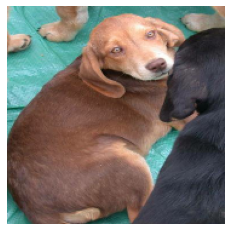

In [3]:
# display elements in the dataset
for image, label in training_dataset.take(1):
    plt.axis("off")
    plt.imshow(image[0].numpy().astype("uint8"))
    print(label[0].numpy())

In [6]:
# define our model :D
# a data augmentation layer for more generalizability
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 176, 176, 32  2400        ['rescaling[0][0]']          

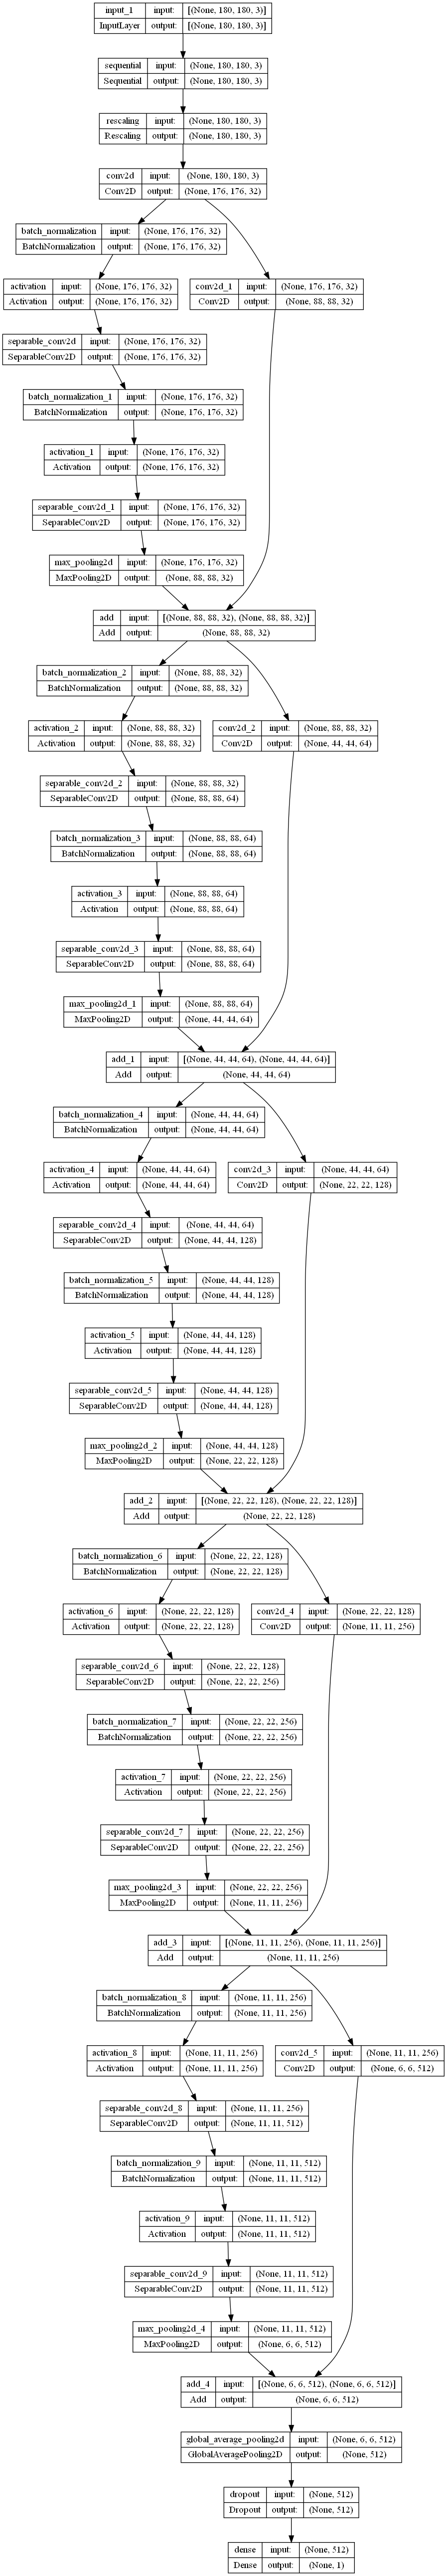

In [7]:
keras.utils.plot_model(model, show_shapes=True)

In [33]:
num_epoch = 100
callbacks=[
    keras.callbacks.ModelCheckpoint(filepath="xception.keras", save_best_only=True, monitor="val_accuracy")
]
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(training_dataset, epochs=num_epoch, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
 8/63 [==>...........................] - ETA: 1:25 - loss: 0.7965 - accuracy: 0.5938

KeyboardInterrupt: 

In [ ]:
epochs = range(1, num_epoch + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.figure()
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, accuracy, "bo", labels="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", labels="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [5]:
loaded_model = keras.models.load_model("./xception.keras")
test_loss, test_acc = loaded_model.evaluate(test_dataset)


63/63 [==============================] - 24s 376ms/step - loss: 0.3613 - accuracy: 0.8725